In [1]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
import optuna
import seaborn as sns

In [2]:
# load in 2022 mlb season data

df = pd.read_csv(r'C:\Users\adam.bloebaum\.vscode\driveline\2022_MLB_Season.csv')

# load in 2023 mlb season data

df_2023 = pd.read_csv(r"C:\Users\adam.bloebaum\.vscode\driveline\2023_MLB_Season.csv")

In [3]:
# load in linear weights for events

linear_weights = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\linear_weights.csv")

In [4]:
# load in calculated expected metrics

#xpfx_x = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2022&3_pfx_x_predictions.csv")
xpfx_x = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\pfx_2022&3_xpfx.csv")

#xpfx_z = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2022&3_pfx_z_predictions.csv")
xpfx_z = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\IVB_2022&3_xpfz.csv")

#xspin_axis = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2022&3_spin_axis_predictions.csv")
xspin_axis = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\axis_2022&3_xaxis.csv")

xswing = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\swing_2022&3_xswing.csv")
xwhiff = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\whiff_2022&3_xwhiff.csv")

xfb = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\fb_2022&3_xfb.csv")
xgrb = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\gb_2022&3_xgb.csv")
xld = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\ld_2022&3_xld.csv")
xfoul = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\foul_2022&3_xfoul.csv")

xcs = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\cs_2022&3_xcalledstrike.csv")

In [5]:
# rename and drop columns from expected dfs

xpfx_x = xpfx_x[['pitch_id_raw', 'xpfx_x']]
xpfx_z = xpfx_z[['pitch_id_raw', 'xpfx_z']]

xspin_axis = xspin_axis[['pitch_id_raw', 'xspin_axis']]

xswing = xswing[['pitch_id_raw', 'xswing']]
xwhiff = xwhiff[['pitch_id_raw', 'xwhiff']]

xfb = xfb[['pitch_id_raw', 'xfb']]
xgrb = xgrb[['pitch_id_raw', 'xgb']]
xld = xld[['pitch_id_raw', 'xld']]
xfoul = xfoul[['pitch_id_raw', 'xfoul']]
xcs = xcs[['pitch_id_raw', 'xcs']]

In [6]:
# ensure df is sequential

df.sort_values(by=['game_pk', 'inning', 'at_bat_number', 'pitch_number'], inplace=True)

# convert batter handedness columns to binary

stand_encoder = LabelEncoder()
all_stand = pd.concat([df['stand'], df_2023['stand']]).unique()
stand_encoder.fit(all_stand)

df['stand'] = stand_encoder.transform(df['stand'])

# generate unique id column

df['pitch_id_raw'] = df['game_pk'].astype(str) + "_" + \
                            df['batter'].astype(str) + "_" + \
                            df['pitcher'].astype(str) + "_" + \
                            df['pitch_number'].astype(str) + "_" + \
                            df['at_bat_number'].astype(str) + "_" + \
                            df['inning'].astype(str)

# select only fastballs 11/10 took out cutters

df = df[df['pitch_type'].isin(['FF', 'SI', 'FA', 'FT'])]

# normalize LHP values to RHP standards

df.loc[df['p_throws'] == 'L', 'pfx_x'] = df['pfx_x'] * -1
df.loc[df['p_throws'] == 'L', 'release_pos_x'] = df['release_pos_x'] * -1
df['spin_axis'] = 360 - df['spin_axis']

# total movement column

df['pfx_total'] = abs(df['pfx_x']) + abs(df['pfx_z'])

# movement ratio column

df['pfx_x_ratio'] = abs(df['pfx_x']) / df['pfx_total']
df['pfx_z_ratio'] = abs(df['pfx_z']) / df['pfx_total']

In [7]:
# ensure df is sequential

df_2023.sort_values(by=['game_pk', 'inning', 'at_bat_number', 'pitch_number'], inplace=True)

# convert batter handedness columns to binary

df_2023['stand'] = stand_encoder.transform(df_2023['stand'])

# generate unique id column

df_2023['pitch_id_raw'] = df_2023['game_pk'].astype(str) + "_" + \
                            df_2023['batter'].astype(str) + "_" + \
                            df_2023['pitcher'].astype(str) + "_" + \
                            df_2023['pitch_number'].astype(str) + "_" + \
                            df_2023['at_bat_number'].astype(str) + "_" + \
                            df_2023['inning'].astype(str)

# select only fastballs 11/10 took out cutters

df_2023 = df_2023[df_2023['pitch_type'].isin(['FF', 'SI', 'FA', 'FT'])]

# normalize LHP values to RHP standards

df_2023.loc[df_2023['p_throws'] == 'L', 'pfx_x'] = df_2023['pfx_x'] * -1
df_2023.loc[df_2023['p_throws'] == 'L', 'release_pos_x'] = df_2023['release_pos_x'] * -1
df_2023['spin_axis'] = 360 - df['spin_axis']

# total movement column
df_2023['pfx_total'] = abs(df_2023['pfx_x']) + abs(df_2023['pfx_z'])

# movement ratio column
df_2023['pfx_x_ratio'] = abs(df_2023['pfx_x']) / df_2023['pfx_total']
df_2023['pfx_z_ratio'] = abs(df_2023['pfx_z']) / df_2023['pfx_total']

In [8]:
# create outcome column using events and description columns

events_mapping = {
    'field_out': 'field_out',
    'force_out': 'field_out',
    'fields_choice_out': 'field_out',
    'fielders_choice': 'field_out',
    'other_out': 'field_out',
    'sac_fly': 'field_out',
    'sac_bunt': 'field_out',
    'walk': 'walk',
    'hit_by_pitch': 'walk',
    'strikeout': 'strikeout',
    'grounded_into_double_play': 'double_play',
    'double_play': 'double_play',
    'strikeout_double_play': 'double_play',
    'sac_fly_double_play': 'double_play',
    'single': 'single',
    'double': 'double',
    'triple': 'triple',
    'home_run': 'home_run'    
}


description_mapping = {
    'ball': 'ball',
    'called_strike': 'strike',
    'foul': 'foul',
    #'hit_into_play': 'hit_into_play',
    'swinging_strike': 'strike',
    'foul_tip': 'foul',
    'hit_by_pitch': 'walk',
    'blocked_ball': 'ball' ,
    'missed_bunt': 'strike',
    'foul_bunt': 'foul',
    'swinging_strike_blocked': 'strike',
    'bunt_foul_tip': 'foul'
}

In [9]:
# function for using mappings to determine outcome

def determine_outcome(row):
    
    event = row['events']
    description = row['description']
    
    if event in events_mapping:
        return events_mapping[event]

    elif description in description_mapping:
        return description_mapping[description]

    else:
        return np.nan

# apply function to each row

df['outcome'] = df.apply(determine_outcome, axis=1)
df_2023['outcome'] = df_2023.apply(determine_outcome, axis=1)

In [10]:
# drop na outcome rows

df.dropna(subset=['outcome'], inplace=True)
df_2023.dropna(subset=['outcome'], inplace=True)

In [11]:
# create outcome label encoder

outcome_encoder = LabelEncoder()

# get all possible outcome values

all_outcome = pd.concat([df['outcome'], df_2023['outcome']]).unique()
outcome_encoder.fit(all_outcome)

# label encode the outcome column

df['outcome'] = outcome_encoder.transform(df['outcome'])
df_2023['outcome'] = outcome_encoder.transform(df_2023['outcome'])

In [12]:
# perform left joins

df = pd.merge(df, xpfx_x, on='pitch_id_raw', how='left')
df = pd.merge(df, xpfx_z, on='pitch_id_raw', how='left')
df = pd.merge(df, xspin_axis, on='pitch_id_raw', how='left')
df = pd.merge(df, xswing, on='pitch_id_raw', how='left')
df = pd.merge(df, xwhiff, on='pitch_id_raw', how='left')

df = pd.merge(df, xfb, on='pitch_id_raw', how='left')
df = pd.merge(df, xgrb, on='pitch_id_raw', how='left')
df = pd.merge(df, xld, on='pitch_id_raw', how='left')
df = pd.merge(df, xfoul, on='pitch_id_raw', how='left')
df = pd.merge(df, xcs, on='pitch_id_raw', how='left')


# perform left joins

df_2023 = pd.merge(df_2023, xpfx_x, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xpfx_z, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xspin_axis, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xswing, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xwhiff, on='pitch_id_raw', how='left')

df_2023 = pd.merge(df_2023, xfb, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xgrb, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xld, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xfoul, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xcs, on='pitch_id_raw', how='left')

In [13]:
# convert all negative swing probabilities to zero (bug)

df.loc[df['xswing'] < 0, 'xswing'] = 0
df_2023.loc[df_2023['xswing'] < 0, 'xswing'] = 0

In [14]:
# create combination term of swing and whiff probabilities

df['swing_whiff'] = df['xswing'] * df['xwhiff']
df_2023['swing_whiff'] = df_2023['xswing'] * df_2023['xwhiff']

In [306]:
df.to_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2022_MLB_xfeatures.csv")

In [15]:
# feature selection and data splitting

columns = ['outcome', 'player_name', 'pitch_type', 'spin_axis', 'ax', 'vz0', 'az', 'vx0', 'ay', 'vy0', 'release_speed', 'release_pos_x', 'release_pos_y', \
           'release_pos_z', 'release_extension', 'release_spin_rate', 'pfx_z', 'pfx_x', 'pfx_total', 'pfx_x_ratio', 'pfx_z_ratio',\
           'xpfx_x', 'xpfx_z', 'xspin_axis', 'xswing', 'xwhiff', 'swing_whiff', 'xfb', 'xgb', 'xld', 'xfoul', 'xcs', 'delta_run_exp']

features = ['spin_axis', 'ax', 'vz0', 'az', 'vx0', 'ay', 'vy0', 'release_speed', 'release_pos_x', 'release_pos_y', \
           'release_pos_z', 'release_extension', 'release_spin_rate', 'pfx_z', 'pfx_x', 'pfx_total', 'pfx_x_ratio', 'pfx_z_ratio',\
           'xpfx_x', 'xpfx_z', 'xspin_axis', 'xswing', 'xwhiff', 'swing_whiff', 'xfb', 'xgb', 'xld', 'xfoul', 'xcs']

# drop any rows with nan values
df = df[columns]
df = df.dropna()

# create features and targets

X = df[features]
y = df['outcome']


In [16]:
# train valid test split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# optuna tuning block

def objective(trial):
    
    # define hyperparameters
    
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'learning_rate': trial.suggest_float('eta', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'objective': 'multi:softmax',
        'num_class': len(np.unique(y_train)),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }

    # initialize model
    
    model = xgb.XGBClassifier(**params, n_estimators=100)

    # train the model
    
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=50, verbose=False)

    # predict on validation set
    
    y_valid_pred = model.predict_proba(X_valid)

    # calculate log loss on the validation set
    
    loss = log_loss(y_valid, y_valid_pred)

    return loss

#create an optuna study and specifcy the the direction of the optimization

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# print best parameters

print(study.best_params)

In [17]:
# set up model

params = {
        'max_depth': 8,
        'eta': 0.095694,
        'subsample': 0.884399,
        'colsample_bytree': 0.999829,
        'objective': 'multi:softmax',
        'num_class': len(np.unique(y_train)),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }

# initialize model
    
model = xgb.XGBClassifier(**params, n_estimators=100)

# train model

model.fit(X_train, y_train)

c:\Users\adam.bloebaum\AppData\Local\miniconda3\envs\driveline\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.999829, early_stopping_rounds=None,
              enable_categorical=False, eta=0.095694, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_class=11, num_parallel_tree=None, ...)

In [18]:
# make predictions

y_pred = model.predict(X_valid)

# evaluate the model

accuracy = accuracy_score(y_valid, y_pred)
conf_matrix = confusion_matrix(y_valid, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')

Accuracy: 0.5403240907454088
Confusion Matrix:
[[17797     0     0    45  1299     0     0  2295   117     0    28]
 [   52     0     0    19   418     0     0   283    15     0     1]
 [   42     0     0    12   186     0     0   142     9     0     2]
 [  697     0     1   119  4273     0     0  2651   154     0    35]
 [ 1683     0     0   147  7734     0     0  4696   295     0   102]
 [   21     0     0     3   234     0     0   238     8     0     1]
 [  239     0     0    47  1439     0     0   901    59     0    13]
 [ 2099     0     0    31  2597     0     0 10706     0     0    78]
 [  675     0     0    88  2119     0     0     2   361     0    66]
 [    2     0     0     1    32     0     0    23     1     0     1]
 [  693     0     0    12   265     0     0   179    47     0   795]]


<Figure size 1000x5000 with 0 Axes>

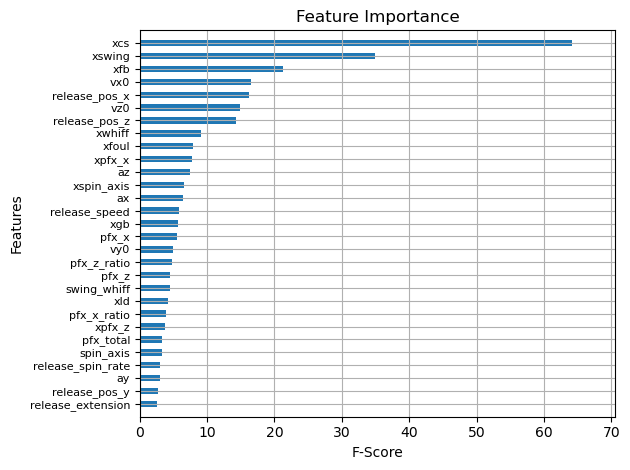

In [19]:
plt.figure(figsize=(10, 50))  # You may adjust this if needed
xgb.plot_importance(model, importance_type='gain', show_values=False, height=0.5)
plt.title('Feature Importance')
plt.xlabel('F-Score')
plt.ylabel('Features')
plt.yticks(fontsize=8)  # You can adjust fontsize if the labels are too crowded
plt.tight_layout()  # Adjust the layout to fit all labels and titles
plt.savefig('feature_importance_fb.png', dpi=300)  # Save with high resolution
plt.show()

In [20]:
# get feature importance dictionary

importance = model.get_booster().get_score(importance_type='gain')

# sort features by importance

sorted_importance = sorted(importance.items(), key=lambda item: item[1], reverse=True)

# loop to print

for feature, score in sorted_importance:
    print(f'{feature}: {score}')

xcs: 64.17366027832031
xswing: 34.9791145324707
xfb: 21.314062118530273
vx0: 16.510034561157227
release_pos_x: 16.221580505371094
vz0: 14.840875625610352
release_pos_z: 14.336505889892578
xwhiff: 9.148512840270996
xfoul: 7.831366062164307
xpfx_x: 7.7289137840271
az: 7.526653289794922
xspin_axis: 6.622251510620117
ax: 6.428939342498779
release_speed: 5.882035255432129
xgb: 5.65302038192749
pfx_x: 5.4575676918029785
vy0: 4.954222679138184
pfx_z_ratio: 4.8238630294799805
pfx_z: 4.501096725463867
swing_whiff: 4.484053134918213
xld: 4.2282586097717285
pfx_x_ratio: 3.918494462966919
xpfx_z: 3.7170968055725098
pfx_total: 3.338045358657837
spin_axis: 3.2798871994018555
release_spin_rate: 3.0709309577941895
ay: 3.0100009441375732
release_pos_y: 2.732391357421875
release_extension: 2.621243715286255


In [21]:
# copy and keep only features

df_2023_features = df_2023[features]

# generate outcome probabilities on 2023 mlb season data

outcome_probabilities = model.predict_proba(df_2023_features)

# apply outcome probabilities back onto full df

for i, class_label in enumerate(model.classes_):
    df_2023[f'prob_{class_label}'] = outcome_probabilities[:, i]

In [22]:
# label encode linear weights to match outcome

linear_weights = linear_weights[linear_weights['description'] != 'caught_stealing_2b']
linear_weights['outcome'] = outcome_encoder.transform(linear_weights['description'])

In [23]:
linear_weight_values = linear_weights.set_index('outcome')['linear_weight']

# weighted sum of each outcome's probability * each outcome's linear weight run value

df_2023['pitch_quality'] = sum(
    df_2023[f'prob_{i}'] * linear_weight_values[i] for i in range(11)
)

In [24]:
# group by player name and pitch type for pitches a player threw more than 100 times

grouped_data = df_2023.groupby(['player_name', 'pitch_type']).filter(lambda x: len(x) > 100)

# group by player name and pitch type and get the mean pitch quality

pitch_quality_sum = grouped_data.groupby(['player_name', 'pitch_type'])['pitch_quality'].mean().reset_index()

# sort the results by pitch quality in descending order and take the top 10

top_10 = pitch_quality_sum.sort_values(by='pitch_quality', ascending=False).head(10)

# sort the results by pitch quality in ascending order and take the bottom 10

bottom_10 = pitch_quality_sum.sort_values(by='pitch_quality', ascending=True).head(10)

# print results

print("Top 10:")
print(top_10)
print("\nBottom 10:")
print(bottom_10)

Top 10:
           player_name pitch_type  pitch_quality
721   Wainwright, Adam         FF       0.031504
177     Duarte, Daniel         SI       0.031388
731     Ward, Thaddeus         SI       0.028780
36        Bard, Daniel         FF       0.027876
527       Patiño, Luis         SI       0.026692
236    Germán, Domingo         SI       0.026202
175       Doyle, Tommy         FF       0.025184
597  Saalfrank, Andrew         SI       0.025091
66     Blackburn, Paul         SI       0.024623
382    Lamet, Dinelson         FF       0.024196

Bottom 10:
           player_name pitch_type  pitch_quality
120   Chapman, Aroldis         SI      -0.029331
569    Rasmussen, Drew         FF      -0.015690
769  Woodruff, Brandon         FF      -0.013679
25    Armstrong, Shawn         FF      -0.013187
660   Strider, Spencer         FF      -0.012076
261        Green, Chad         FF      -0.011360
779      deGrom, Jacob         FF      -0.010160
284      Helsley, Ryan         FF      -0.009698


In [25]:
# determine max and min avg pitch quality values

max_val = pitch_quality_sum['pitch_quality'].max()
min_val = pitch_quality_sum['pitch_quality'].min()

# create normalized stuff+ metric centered around 100

pitch_quality_sum['stuff_plus'] = max_val - pitch_quality_sum['pitch_quality']
mean_stuff = pitch_quality_sum['stuff_plus'].mean()
scaling_factor = 100 / mean_stuff
pitch_quality_sum['stuff_plus'] = pitch_quality_sum['stuff_plus'] * scaling_factor
pitch_quality_sum['stuff_plus'] += 100 - pitch_quality_sum['stuff_plus'].mean()

# sort by stuff plus in ascending order

sorted_pitch_quality_sum = pitch_quality_sum.sort_values(by='stuff_plus', ascending=False)

# reset index and +1 to get rank column

sorted_pitch_quality_sum = sorted_pitch_quality_sum.reset_index()
sorted_pitch_quality_sum.index = sorted_pitch_quality_sum.index + 1

# convert to int for rounding

sorted_pitch_quality_sum['stuff_plus'] = sorted_pitch_quality_sum['stuff_plus'].astype(int)

# print name, pitch type, and stuff plus top 50

sorted_pitch_quality_sum[['player_name', 'pitch_type', 'stuff_plus']].head(25)

,player_name,pitch_type,stuff_plus
1,"Chapman, Aroldis",SI,250
2,"Rasmussen, Drew",FF,194
3,"Woodruff, Brandon",FF,186
4,"Armstrong, Shawn",FF,184
5,"Strider, Spencer",FF,179
6,"Green, Chad",FF,176
7,"deGrom, Jacob",FF,171
8,"Helsley, Ryan",FF,169
9,"Pagán, Emilio",FF,168
10,"Estrada, Jeremiah",FF,167


In [26]:
# select top 25 rows

top_25_rows = sorted_pitch_quality_sum[['player_name', 'pitch_type', 'stuff_plus']].head(25)

# plotting rankings as a table

fig, ax = plt.subplots(figsize=(5, 6))
ax.axis('tight')
ax.axis('off')
ax.set_title('Top 25 Fastball Stuff+')
table = ax.table(cellText=top_25_rows.values,
                 colLabels=top_25_rows.columns,
                 loc='center',
                 cellLoc='center',
                 colLoc='center',
                 colWidths=[0.4, 0.2, 0.2])
plt.tight_layout()

# save fig and close

plt.savefig(r'C:\Users\adam.bloebaum\.vscode\driveline\stuff_plus_fb_v7.png', dpi=300)
plt.close()

In [27]:
# save 2022 and 2023 dfs to y drive

df.to_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2022_MLB_xfeatures_outcome_probs_stuff_plus.csv")
df_2023.to_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2023_MLB_xfeatures__outcome_probs_stuff_plus.csv")

In [28]:
# heater avg metrics function for breaking ball model

def heater_stats(df):
    grouped_df = df.groupby(['player_name', 'pitch_type'])[['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'xpfx_x', 'pfx_z', 'xpfx_z', 'ax', 'ay', 'az', 'vx0', 'vy0', 'vz0', 'release_spin_rate', 'release_extension', 'spin_axis']].mean().reset_index()
    idx = grouped_df.groupby(['player_name'])['release_speed'].transform(max) == grouped_df['release_speed']
    heater_df = grouped_df[idx]
    heater_df = heater_df.groupby('player_name').head(1).reset_index(drop=True)
    final_df = heater_df.rename(columns={col: f'fb_{col}' if col != 'player_name' else col for col in heater_df.columns})
    return final_df

heaters_2022 = heater_stats(df)

heaters_2022[heaters_2022['player_name'] == 'Armstrong, Shawn']

,player_name,fb_pitch_type,fb_release_speed,fb_release_pos_x,fb_release_pos_z,fb_pfx_x,fb_xpfx_x,fb_pfx_z,fb_xpfx_z,fb_ax,fb_ay,fb_az,fb_vx0,fb_vy0,fb_vz0,fb_release_spin_rate,fb_release_extension,fb_spin_axis
30,"Armstrong, Shawn",SI,95.574468,-2.044016,5.822952,-1.290957,-1.107334,0.950452,0.963547,-18.405482,31.567668,-18.867112,7.555953,-138.901264,-5.227936,2151.760638,6.6375,146.87766


In [29]:
# group by pitcher and pitch type

pp = df_2023.groupby(['player_name', 'pitch_type'])

# calculate sum of delta run expectancy and count of pitches for each pitcher's pitch

rv = pp.agg(total_delta_run_exp=('delta_run_exp', 'sum'),
                      total_pitches=('delta_run_exp', 'count'))

# calculate run value per 100 pitches

rv['run_value_per_100_pitches'] = (rv['total_delta_run_exp'] / rv['total_pitches']) * 100

# filter for pitches thrown at least 100 times and sort

rv = rv[rv['total_pitches'] > 100]
rv = rv.sort_values(by='run_value_per_100_pitches')

# merge with sorted pitch quality sum on player name and pitch type

model_validation_df = pd.merge(sorted_pitch_quality_sum, rv, on=['player_name', 'pitch_type'], how='left')

c:\Users\adam.bloebaum\AppData\Local\miniconda3\envs\driveline\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


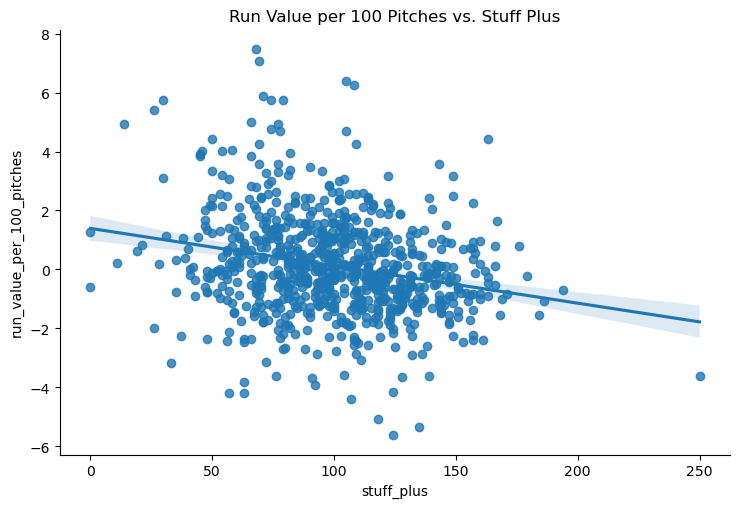

In [32]:
# scatter plot with a regression line

sns.lmplot(x='stuff_plus', y='run_value_per_100_pitches', data=model_validation_df, aspect=1.5)
plt.title('Run Value per 100 Pitches vs. Stuff Plus')
plt.savefig(r'C:\Users\adam.bloebaum\.vscode\driveline\validation_02.png', dpi=300)
plt.savefig('run_value_validation_plot.png', dpi=300)
plt.show()

In [31]:
# correlation coefficient

correlation = model_validation_df['stuff_plus'].corr(model_validation_df['run_value_per_100_pitches'])
print(f"Correlation Coefficient: {correlation}")


from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score

slope, intercept, r_value, p_value, std_err = stats.linregress(model_validation_df['stuff_plus'], model_validation_df['run_value_per_100_pitches'])
predicted_values = slope * model_validation_df['stuff_plus'] + intercept

# mse and rmse

mse = mean_squared_error(model_validation_df['run_value_per_100_pitches'], predicted_values)
rmse = np.sqrt(mse)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

# rsquared

r_squared = r2_score(model_validation_df['run_value_per_100_pitches'], predicted_values)
print(f"R-squared: {r_squared}")

Correlation Coefficient: -0.23722359581836677
Mean Squared Error: 2.7556610011914793
Root Mean Squared Error: 1.66001837375117
R-squared: 0.05627503441299597
